# Spectral Clustering of Brain Regions

## Introduction
This code uses `sklearn` to calculate the Spectral Clustering of regions in the brain based on their connectivities.<br>
Connectivity matrices from https://doi.org/10.1371/journal.pone.0014832 <br>
Clustering method as in https://doi.org/10.1371/journal.pone.0035029 <br>
First let us import the appropriate modules.

In [1]:
from scipy.io import loadmat    # needed for loading .mat matlab files
import numpy as np              # for vector math
import os                       # for getting absolute path to files in your directory
import sklearn.cluster          # for spectral clustering (and other clustering methods)
import matplotlib.pyplot as plt # for plotting
from nilearn import plotting    # for plotting glass brains
import pandas as pd             # for easier data manipulation

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # ignore silly warnings

## Define functions
Create a function to find files in the `./data/` subfolder

In [5]:
def get_path(filename):
    """Find filename in the relative directory ./data/

    Args:
        filename (str): file we're looking for in the ./data/ directory.

    Returns:
        str: absolute path to file "filename" in ./data/ dir.

    """

    here_dir = os.path.dirname(os.path.realpath('__file__'))
    file_dir = os.path.join(here_dir, 'data', filename)

    return(file_dir)

Return connectivity matrices from .mat file

In [7]:
def get_connectivity_matrices(filepath):
    """Read connectivity matrices from .mat file.
    File contains matrices for 14 healthy individuals
    if using, cite: https://doi.org/10.1371/journal.pone.0014832

    Args:
        filepath (str): full path to .mat file containing connectivity matrices.

    Returns:
        arr: Array of connectivity matrices, one per patient.

    """

    from pathlib import Path
    my_file = Path(filepath)

    if my_file.is_file():
        conn_matrices = loadmat(my_file)['S']
        conn_matrices = np.transpose(conn_matrices)
        return(conn_matrices)

    else:
        print(my_file)
        raise(FileNotFoundError('Is path to file correct??'))

Define function to plot the glass brains using `nilearn`

In [8]:
def plot_glass_brain(color):
    """Plot a glass brain for a 90 regions ATLAS with nodes colored according to `color` array.

    Args:
        color (list): Color indices according to which brain regions will be colored / grouped by.

    Returns:
        matplotlib.plot: A plot object.

    """

    coordinates_path = get_path('coordinates.csv')
    df = pd.read_csv(coordinates_path)

    # AAL has 116 regions but we're not interested in the last 26 (cerebellar structures)
    coords = [(df['X'][i],df['Y'][i],df['Z'][i]) for i in range(90)]
    
    # Connections between the regions are required for plotting but they make
    # everything cluttered so let's just make an array of zeros:
    connec = np.array([[0]*90]*90)

    plotting.plot_connectome(connec, coords, node_color=color, display_mode='lyrz')

## Calculate spectral clustering
Now we are ready to start. <br>
We will first find and define a connectivity matrix first:

In [9]:
# find .mat file containing connectivity matrices
conn_matrices_dir = get_path('connectivity_matrices.mat')
# connectivity matrices for 14 healthy subjects
conn_matrices     = get_connectivity_matrices(conn_matrices_dir)

Spectral clustering works by clustering elements that are **near** each other. We however want to cluster brain regions based on their **connectivity strength**. We therefore have to do 2 things:<br>
**1. Invert connectivity matrix** so that large values (high connectivity) become close to zero (near each other in 'similarity' space)


In [11]:
#we will invert the connectivity matrix (1/M) so lets get rid of zeros
shifted_matrices    = conn_matrices + 0.0001
#similarity matrices are the inverted connectivity matrices
similarity_matrices = (1/ shifted_matrices)

**2. Normalize the matrix** so that values are between [0,1]. We will use a Gaussian kernel as suggested [here](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html) <br>
The `gauss_parameter` below is key, since it basically decides the cutoff for filtering the data using the Gaussian kernel:

In [12]:
gauss_parameter     = 0.005
kernelized_matrices = np.exp(- similarity_matrices ** 2 / (2. * gauss_parameter ** 2))

We then define the `Spectral Clustering` function that will be applied to the data and apply it

In [13]:
 #we choose to classify the data into 2 clusters
spectral   = sklearn.cluster.SpectralClustering(n_clusters=2, affinity='precomputed')
patient_ID = 0
spectral.fit(kernelized_matrices[patient_ID])

SpectralClustering(affinity='precomputed', assign_labels='kmeans', coef0=1,
          degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
          kernel_params=None, n_clusters=2, n_init=10, n_jobs=None,
          n_neighbors=10, random_state=None)

Now we will use the labels, created by the `Spectral Clustering` method, to color the nodes in the glass brain differently

In [14]:
#array of integer labels referrent to which class the node belongs to
color = spectral.labels_ 

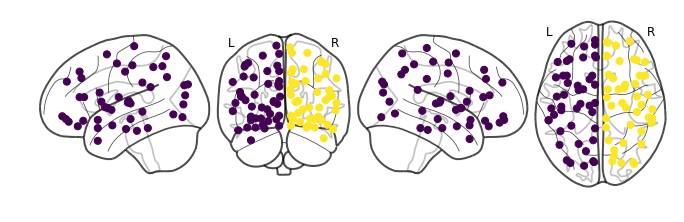

In [15]:
plot_glass_brain(color)

## Wait what?
**That's right!** If one uses spectral clustering to classify brain regions based solely on their connectivity (with **no information about their location**) the natural separation (i.e. the one that minimizes cross-connections between nodes belonging to different classes) separates the brain into *left* and *right* lobes.

This is the finding of [Ivković *et al.* in their 2012 PLoS paper](https://doi.org/10.1371/journal.pone.0035029). Quite remarkable!!

## More regions
What would happen if we try to classify the 90 brain regions into more categories? Lets try 4:

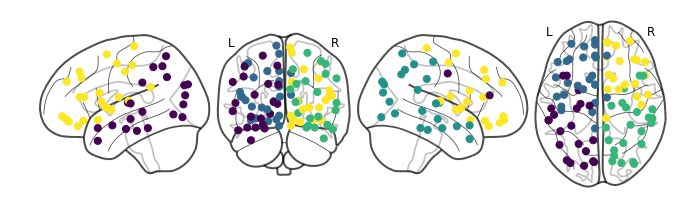

In [16]:
spectral   = sklearn.cluster.SpectralClustering(n_clusters=4, affinity='precomputed')
patient_ID = 0
spectral.fit(kernelized_matrices[patient_ID])
color = spectral.labels_
plot_glass_brain(color)

**Woah!** More than left and right lobes, we now can see the frontal vs parietal lobe separation too.
Finally for 5 different classes we see:

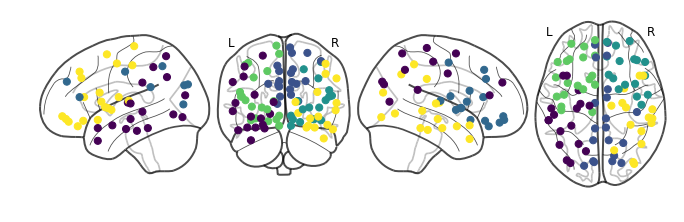

In [17]:
spectral   = sklearn.cluster.SpectralClustering(n_clusters=5, affinity='precomputed')
patient_ID = 0
spectral.fit(kernelized_matrices[patient_ID])
color = spectral.labels_
plot_glass_brain(color)